In [1]:
import warnings
notebook_warnings = []
def warning_collector(message, category, filename, lineno, file=None, line=None):
    notebook_warnings.append(f"{category.__name__}: {message} (File {filename}, line {lineno})")
warnings.showwarning = warning_collector


In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2019 - 2024 United Kingdom Research and Innovation
#  Copyright 2019 - 2024 Technical University of Denmark
#  Copyright 2019 - 2022 The University of Manchester
#  Copyright 2019 - 2022 The University of Bath
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Claire Delplancke (University of Bath)
#                   Evangelos Papoutsellis (UKRI-STFC)
#                   Gemma Fardell (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)  
#                   Margaret Duff (UKRI-STFC)
#                   Hannah Robarts (UKRI-STFC)

# Stochastic Primal Dual Hybrid Gradient Algorithm: Tomography

 In this demo, we learn how to use the Stochastic Primal-Dual Hybrid (SPDHG) algorithm introduced in [Chambolle et al.](https://arxiv.org/abs/1706.04957), see as well [Ehrhardt et al.](https://arxiv.org/abs/1808.07150), [Papoutsellis et al.](https://arxiv.org/abs/2102.06126), [Gutierrez et al.](https://arxiv.org/abs/2012.01255). This algorithm is a stochastic version of the Primal-Dual Hybrid Gradient (PDHG) Algorithm by [Chambolle & Pock](https://hal.archives-ouvertes.fr/hal-00490826/document). We focus on Tomography Reconstruction under an edge-preserving prior, i.e., the __Total variation regularisation__, see [ROF](https://en.wikipedia.org/wiki/Total_variation_denoising). 

 ## Why SPDHG?

In the previous demo, we presented __PDHG__ for tomography reconstruction.

__SPDHG__ is a stochastic version of __PDHG__. As PDHG, SPDHG can solve convex, non necessarily smooth optimization problems and is provenly convergent. 

The central improvement with respect to PDHG is that SPDHG can deal with __subsets of data__, making it computationally more efficient, so that it can deal with **larger datasets**.

For CT and PET for example, the data can be divided into a collection of partial sinograms, each of them corresponding to a subset of the total set of angles. Accordingly, the projection operator $A: X \rightarrow Y$ can be decomposed as $A=(A_1, \dots, A_n): X \rightarrow Y=Y_1\times \dots \times Y_n$ where $n$ is the number of subsets and each $A_i:X \rightarrow Y_i$ is a __partial__ projection.

At each iteration, SPDHG computes only one partial forward and back-projection $A_i,\,A_i^*$ for a randomly chosen index $i$, whereas PDHG computes $A$ and $A^*$. Hence SPDHG requires only a fraction of the computations of PDHG per iteration, which makes it faster per iteration.


## Learning objectives

1. Implement the subsetting
1. Implement default set-up
1. Compare PDHG and SPDHG: notion of epoch, visual comparison, measures (primal objective function)
1. Tweak the default set-up: explicit / implicit, stepsizes


## Prerequisites

Pre-requisites:

1. ImageData, AcquisitionData, Block Framework
1. Projection operator
1. Total Variation (TV)
1. PDHG implicit set-up for tomographic reconstruction. Optional: explicit set-up

## Tomography reconstruction

The minimisation problem for Total Variation Tomography reconstruction with TV is 

$$ \underset{u}{\operatorname{argmin}} \mathcal{O}(u)= \frac{1}{2}\| A u - g\|^{2} + \alpha\,\mathrm{TV}(u) +  \mathbb{I}_{\{u>0\}}(u) \tag{1}$$


where,

1. TV is defined as $$\mathrm{TV}(u) = \|\nabla u \|_{2,1} = \sum \sqrt{ (\partial_{y}u)^{2} + (\partial_{x}u)^{2} }$$
1. g is the Acquisition data obtained from the detector.
1. $A$ is the projection operator ( _Radon transform_ ) that maps from an image-space to an acquisition space, i.e., $A : X \rightarrow Y, $ where X is an __ImageGeometry__ and Y is a __BlockDataContainer__ of __AcquisitionGeometry__ objects.
1. $\alpha$ is a regularising parameter that measures a trade-off between the fidelity and the regulariser terms.
1. The functional $\mathbb{I}_{\{u\geq 0\}}(u) : = 
\begin{cases}
0, & \text{ if } u\geq 0\\
\infty , & \text{ otherwise}
\quad
\end{cases}
$, $\quad$ is a positivity constraint for the minimiser $u$.


### SPDHG form
In order to use the SPDHG algorithm for the problem above, we need to express our minimisation problem into the following form:

$$\min_{u} \sum_{i=1}^n F_i(K_i u) + G(u) \tag{2}$$

where we assume that:

1. $F_i$, $G$ are __convex__ functionals
    
    - $F_i: Y_i \rightarrow \mathbb{R}$ 
    
    - $G: X \rightarrow \mathbb{R}$
    
    
2. $K_i$ is a continuous linear operator acting from a space X to another space Y_i :

$$K_i : X \rightarrow Y_i \quad $$ 

with operator norm  defined as $$\| K_i \| = \max\{ \|K_i x\|_{Y} : \|x\|_{X}\leq 1 \}.$$  

**Note**: We use the [Power Method](https://en.wikipedia.org/wiki/Power_iteration) to approximate the norm of the $K_i$'s and if needed of $\nabla$.

In [3]:
# Import libraries
  
from cil.optimisation.algorithms import PDHG, SPDHG
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.functions import IndicatorBox, BlockFunction, L2NormSquared, MixedL21Norm
 
from cil.io import ZEISSDataReader
 
from cil.processors import Slicer, Binner, TransmissionAbsorptionConverter
 
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV
 
from cil.utilities.display import show2D
from cil.utilities.jupyter import islicer
 
 
import numpy as np
import matplotlib.pyplot as plt
import os

# Data information

In this demo, we use the **Walnut** found in [Jørgensen_et_all](https://zenodo.org/record/4822516#.YLXyAJMzZp8). In total, there are 6 individual micro Computed Tomography datasets in the native Zeiss TXRM/TXM format. The six datasets were acquired at the 3D Imaging Center at Technical University of Denmark in 2014 (HDTomo3D in 2016) as part of the ERC-funded project High-Definition Tomography (HDTomo) headed by Prof. Per Christian Hansen. 

This example requires the dataset walnut.zip from https://zenodo.org/record/4822516 :

    https://zenodo.org/record/4822516/files/walnut.zip

If running locally please download the data and update the `filename` variable below.

In [4]:
filename = "/mnt/share/materials/SIRF/Fully3D/CIL/Walnut/valnut_2014-03-21_643_28/tomo-A/valnut_tomo-A.txrm"

In [5]:
reader = ZEISSDataReader()
reader.set_up(file_name=filename)
data3D = reader.read()

# reorder data to match default order for Astra/Tigre operator
data3D.reorder('astra')

# Get Image and Acquisition geometries
ag3D = data3D.geometry
ig3D = ag3D.get_ImageGeometry()

# Extract vertical slice
data2D = data3D.get_slice(vertical='centre')

# Select every 10 angles
sliced_data = Slicer(roi={'angle':(0,1601,10)})(data2D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2)})(sliced_data)

# Create absorption data 
data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
data -= np.mean(data.as_array()[80:100,0:30])

# Get Image and Acquisition geometries for one slice
ag2D = data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

A = ProjectionOperator(ig2D, ag2D, device = "gpu")

New geometry:  2D Cone-beam tomography
System configuration:
	Source position: [   0.        , -105.05081177]
	Rotation axis position: [0., 0.]
	Detector position: [ 0.        , 45.08757401]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [1024    1]
	Pixel size: [0.0658543 0.0658543]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 161
	Angles 0-9 in radians: [-3.1415665, -3.1022923, -3.0630562, -3.0237632, -2.9845278, -2.945264 ,
 -2.9060063, -2.866688 , -2.8274012, -2.78817  ]
	Angles 151-160 in radians: [2.7881632, 2.8274217, 2.866726 , 2.9059432, 2.9452505, 2.9844823,
 3.0237305, 3.0630383, 3.1023333, 3.1415997]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (161, 1024)
New geometry shape:  (161, 1024)
New geometry:  2D Cone-beam tomography
System configuration:
	Source position: [   0.        , -105.05081177]
	Rot

## How to setup and run SPDHG

In order to setup and run SPDHG, we need to define the following:

- The operator $K=(K_1,\dots,K_n)$.
- The functions $F=(F_1,\dots,F_N)$ and $G$.
- The maximum number of iterations

The setup and run of SPDHG:

` spdhg = SPDHG(f = F, g = G, operator = K)`

` spdhg.run(number_of_iterations)`

We can express our [problem](#Tomography-reconstruction) in the [form](#SPDHG-form), if we let

1. $K = (A_1,\dots,A_n) \quad \Longleftrightarrow \quad $ `K = BlockOperator(A_i)`  

1. $F_i: Y_i \rightarrow \mathbb{R}, \text{ with } F_i(y_i) := \frac{1}{2}\| y_i - g_i \|^{2}, \quad \Longleftrightarrow \quad$ for all $i$'s, `F_i = 0.5*L2NormSquared(data[i])` and  `F = BlockFunction(F_i)` 

1. $G: X \rightarrow \mathbb{R}, \text{ with } G(x) := \alpha\|\nabla x\|_{1} + \mathbb{I}_{\{x>0\}}(x), \quad \Longleftrightarrow \quad$ ` G = alpha * FGP_TV()`.

### Define operator $K$, functions $F$  and $G$

In [6]:
# Define number of subsets
n_subsets = 10

#Sequentially partition the data into the number of subsets using the data partitioner
partitioned_data=data.partition(n_subsets, 'sequential')


# Initialize the lists containing the F_i's
f_subsets = []


# Define F_i's
for i in range(n_subsets):
    # Define F_i and put into list
    fi = 0.5*L2NormSquared(b = partitioned_data[i])
    f_subsets.append(fi)
    
# Define F 
F = BlockFunction(*f_subsets)


#Create the projection operator, K, for the partitioned data
ageom_subset = partitioned_data.geometry
K = ProjectionOperator(ig2D, ageom_subset)


# Define G (set the constraint that the solution must be positive)
alpha = 0.025
G = alpha * FGP_TV(nonnegativity=True)


### Setup and run SPDHG

__Note:__ in this example, there are some parameters which we don't pass, so that SPDHG will use default, pre-defined parameters. These parameters consist of:

1. The probabilities $p_i$ of choosing each subset $i$. By default these probabilities are uniform: if there are $n$ subsets, $p_i=1/n$. We'll see another choice in the part about *explicit set-up*.
1. The step-sizes of the algorithm. To know more about step-sizes setting, refer to the last part of the tutorial.

In [7]:
# Setup and run SPDHG for 50 iterations
spdhg = SPDHG(f = F, g = G, operator = K,
            update_objective_interval = 10)
spdhg.run(50)

spdhg_recon = spdhg.solution    

  0%|          | 0/50 [00:00<?, ?it/s]

### Show reconstruction result

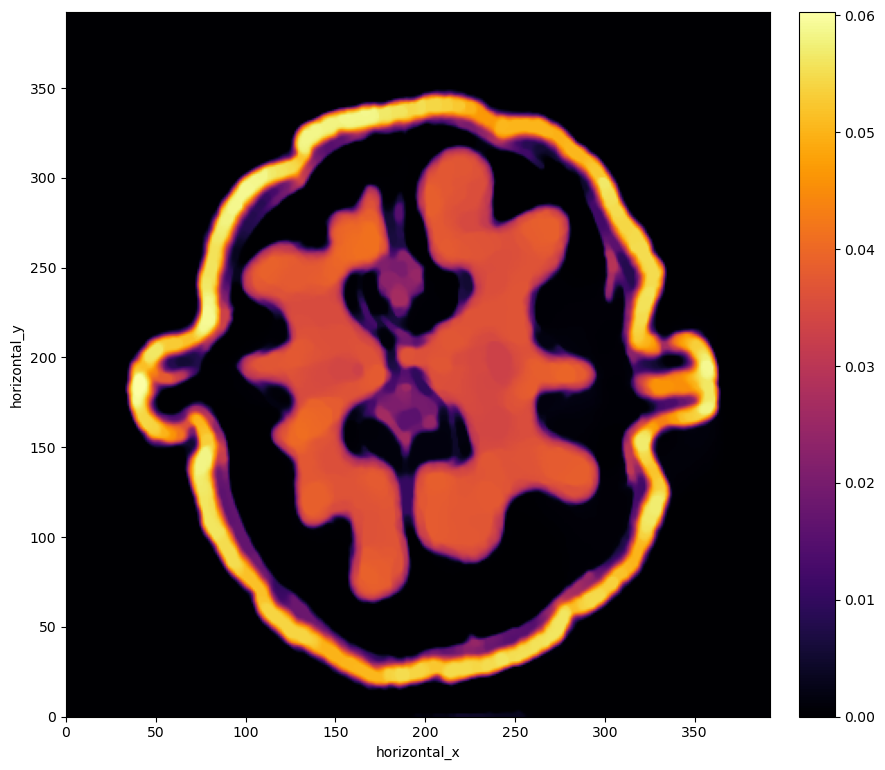

In [8]:
show2D(spdhg_recon, cmap='inferno')

## Comparison to PDHG

PDHG and SPDHG converge to the same set of solutions, but SPDHG is faster per iteration. How can we compare PDHG and SPDHG? We want to compare PDHG and SPDHG **for the same amount of computational effort**. Remember that at each iteration, PDHG computes one entire forward and back-projection, while SPDHG computes only a partial one. For example, if we have 10 subsets, $10$ iterations of SPDHG have the same computational cost than one iteration of PDHG. 

In order to have a fair comparison between both algorithms, we then define the notion of **epoch**, where one epoch corresponds to a full forward and back-projection. Hence, one epoch of PDHG corresponds to one iteration, while one epoch of SPDHG corresponds in our case to $10$ iteration.

Let's set-up and run PDHG and SPDHG for the same number of epochs and compare the results.



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

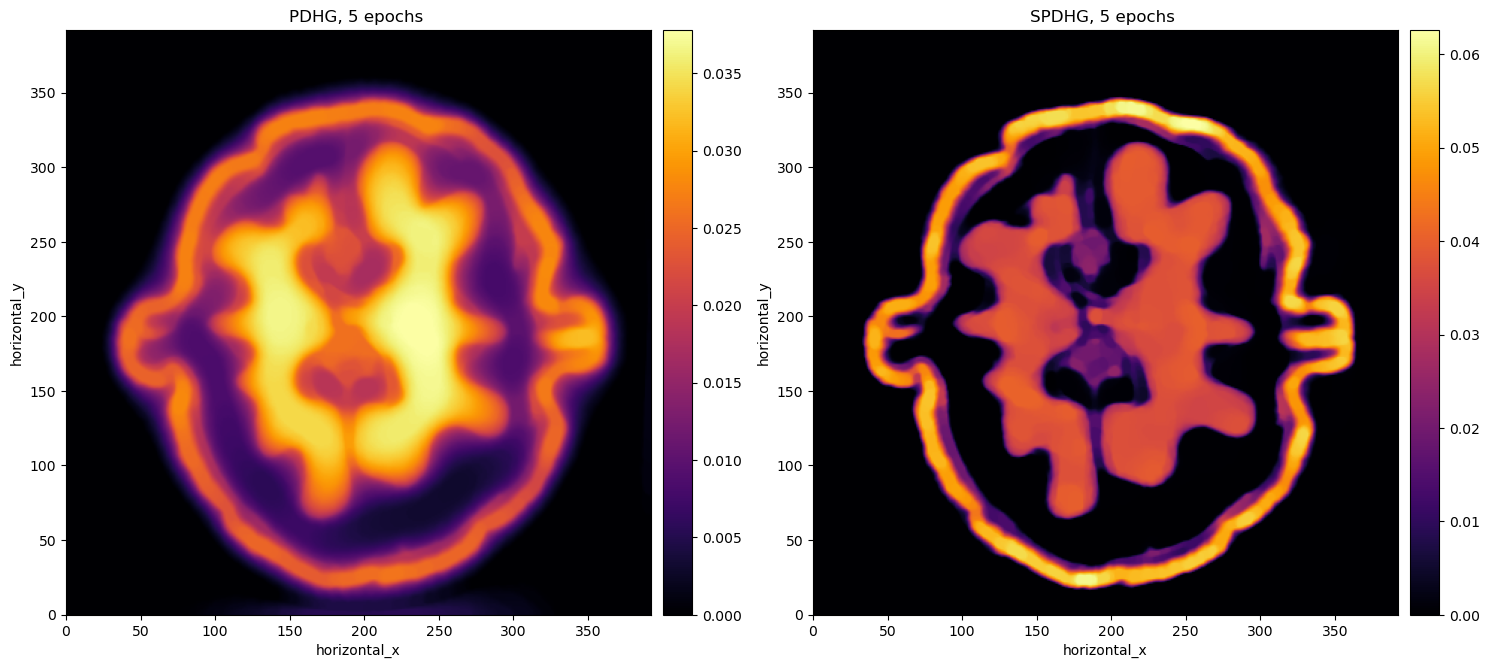

In [9]:
n_epoch = 5

# Setup and run PDHG
normK = K.norm()
tau = 1/normK
sigma = 1/normK
pdhg = PDHG(f = F, g = G, operator = K,
            update_objective_interval = 1, tau=tau, sigma=sigma)
pdhg.run(n_epoch)

pdhg_recon = pdhg.solution

# Setup and run SPDHG
spdhg = SPDHG(f = F, g = G, operator = K,
            update_objective_interval = 1 * n_subsets)
spdhg.run(n_epoch * n_subsets)

spdhg_recon = spdhg.solution

show2D([pdhg_recon, spdhg_recon], cmap='inferno', title = ["PDHG, {} epochs ".format(n_epoch),"SPDHG, {} epochs ".format(n_epoch)])


After 5 epochs, SPDHG reconstruction seems visually more converged than PDHG reconstruction.

To further compare PDHG and SPDHG speeds, let's use a quantitative measure of convergence, which is given by the value of the objective function $\mathcal{O}(u)$.

In [10]:
nepoch = 20
pdhg.run(nepoch)
pdhg_measures = pdhg.objective

spdhg.run(nepoch*n_subsets)
spdhg_measures = spdhg.objective

 24%|##4       | 6/25 [00:00<?, ?it/s]

 20%|##        | 51/250 [00:00<?, ?it/s]

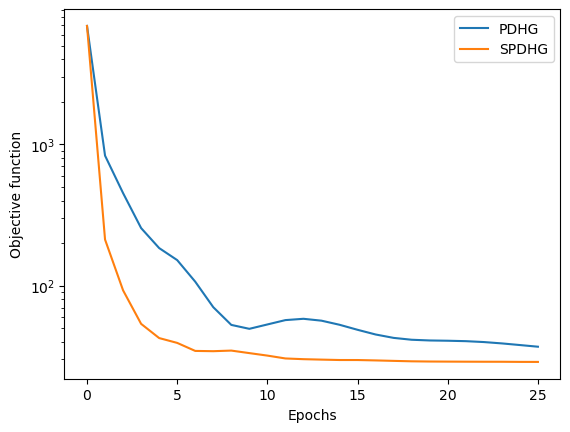

In [11]:
# plot 
epoch_range = np.arange(0,pdhg.iteration+pdhg.update_objective_interval, pdhg.update_objective_interval)
plt.semilogy(epoch_range, pdhg_measures, label='PDHG')
plt.semilogy(epoch_range, spdhg_measures, label='SPDHG')
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.legend()

## Explicit set-up

As for PDHG, there are various ways to put our reconstruction [problem](#Tomography-reconstruction):
$$ \underset{u}{\operatorname{argmin}} \mathcal{O}(u)=  \frac{1}{2}\| A u - g\|^{2} + \alpha\,\mathrm{TV}(u) +  \mathbb{I}_{\{u>0\}}(u) $$
into SPDHG-appropriate [form](#SPDHG_form):
$$\min_{u} \sum_{i=1}^n F_i(K_i u) + G(u).$$ 

*Implicit set-up*

In the first part of the tutorial, we chose the so-called *implicit* set-up, where

1. $K = (A_1,\dots,A_n) \quad \Longleftrightarrow \quad $ `K = BlockOperator(A_i)`  

1. $F_i: Y_i \rightarrow \mathbb{R}, \text{ with } F_i(y_i) := \frac{1}{2}\| y_i - g_i \|^{2}, \quad \Longleftrightarrow \quad$ for all $i$'s, `F_i = 0.5*L2NormSquared(data[i])` and  `F = BlockFunction(F_i)` 

1. $G: X \rightarrow \mathbb{R}, \text{ with } G(x) := \alpha\|\nabla x\|_{1} + \mathbb{I}_{\{x>0\}}(x), \quad \Longleftrightarrow \quad$ ` G = alpha * FGP_TV()`.

*Explicit set-up*

As for PDHG, another way is to include the gradient of $\mathrm{TV}(u)=\alpha \|\nabla u\|_{2,1}$ into the operator $K$:

1. $K = (A_1,\dots,A_n, \nabla) \quad \Longleftrightarrow \quad $ `K = BlockOperator(A_1,...,A_n, Grad)`  

1. For all $1\leq i \leq n, F_i: Y_i \rightarrow \mathbb{R}, \text{ with } F_i(y_i) := \frac{1}{2}\| y_i - g_i \|^{2}$  and $F_{n+1}(z)=\|z\|_{1,2}$, $\quad \Longleftrightarrow \quad$ 

for all $1\leq i \leq n$, `F_i = 0.5*L2NormSquared(data[i])`, `F_{n+1}=MixedL21Norm()` and  `F = BlockFunction(F_i)` 

1. $G: X \rightarrow \mathbb{R}, \text{ with } G(x) := \mathbb{I}_{\{x>0\}}(x), \quad \Longleftrightarrow \quad$ ` G = IndicatorBox(lower=0)`.


## Non-uniform sampling

This time, we also use non-uniform sampling: half of the time, we update the dual variable corresponding to TV, so that $p_{n+1}=1/2$, and half of the time we update one of the dual variable corresponding to one subset, so that $p_i=1/(2n)$ for $1\leq i \leq n$. 

__Comment 1:__ if you don't want to use the default uniform sampling, the probabilities you specify need sum to $1$.

__Comment 2:__ the setting and sampling have an influence on the value of one epoch in terms of iterations. With the sampling defined above, we use the partial forward operator **only half of the time** in mean, so that $1$ epoch (that is, the unit of one entire forward and back-projection) corresponds to twice the number of subsets.

In [12]:
# Define number of subsets
n_subsets = 10

#We sequentially partition the data into the number of subsets using the data partitioner
partitioned_data=data.partition(n_subsets, 'sequential')

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# Define F_i's and A_i's - data fit part
for i in range(n_subsets):
    # Define F_i and put into list
    fi = 0.5 * L2NormSquared(b = partitioned_data[i])
    f_subsets.append(fi)
    # Define A_i and put into list 
    ageom_subset = partitioned_data[i].geometry
    Ai = ProjectionOperator(ig2D, ageom_subset)
    A_subsets.append(Ai)
    
# Define F_{n+1} and A_{n+1} - regularization part
f_reg = ig2D.spacing[0] * alpha * MixedL21Norm() # take into account the pixel size with ig2D.spacing
Grad = GradientOperator(A_subsets[0].domain, backend='c', correlation='SpaceChannel')

# Define F and K
F = BlockFunction(*f_subsets, f_reg)
K = BlockOperator(*A_subsets, Grad)

# Define G
G = IndicatorBox(lower=0)

# Define probabilities
prob = [1 / (2 * n_subsets)] * n_subsets + [1 / 2]

# Setup and run SPDHG for 5 epochs
spdhg_explicit = SPDHG(f = F, g = G, operator = K, 
            update_objective_interval = 2 * n_subsets, prob=prob )
spdhg_explicit.run(5 * 2 * n_subsets)

  0%|          | 0/100 [00:00<?, ?it/s]

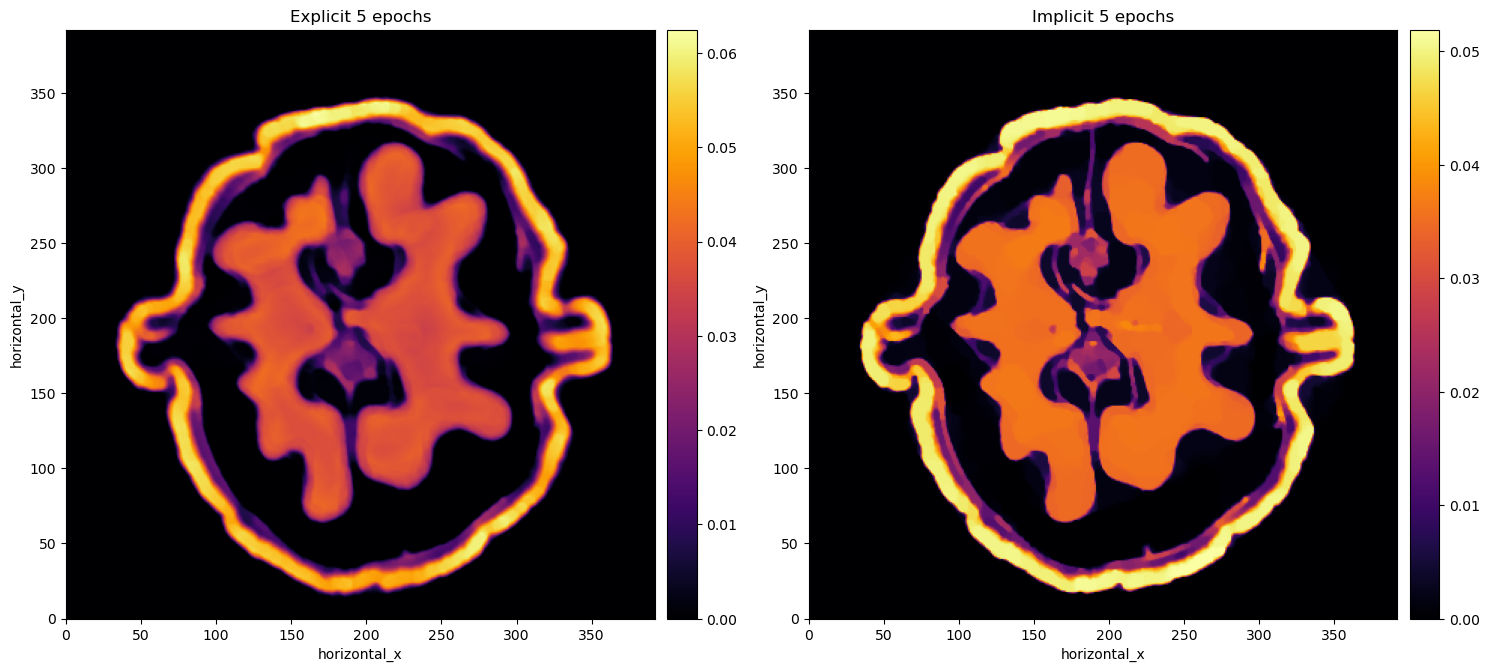

In [13]:
# Show result and compare to implicit framework
spdhg_explicit_recon = spdhg_explicit.get_output()  

show2D([spdhg_explicit_recon, spdhg_recon], cmap='inferno', title= ['Explicit 5 epochs', 'Implicit 5 epochs'])

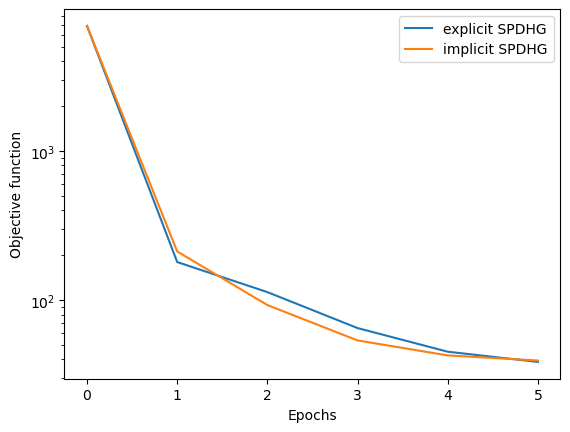

In [14]:
# Comparison of objective function
epoch_range = np.arange(0,6)
plt.semilogy(epoch_range, spdhg_explicit.objective, label='explicit SPDHG')
plt.semilogy(epoch_range, spdhg_measures[0:len(epoch_range)], label='implicit SPDHG')
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.legend()

## Improve the speed of explicit reconstruction by re-normalizing

You can observe that the explicit reconstruction converges slower than the implicit one. However, the block operator $K$ used in the explicit framework is now formed by partial operators $A_{\text{subsets}}[i]$ and $\nabla$ with potentially very different norms. Empirically it hence makes sense to renormalize the partial operators so that they all have norm one. To leave the objective function unchanged, we'd also need to redefine the function $f_i$'s according to the following equations:
$$ \| K u - g\|_2^2 =  \|K\|^2 \cdot \left\| \frac{K}{\|K\|} u - \frac{g}{\|K\|}\right\|_2^2$$
$$ \| \nabla u\|_{2,1} =  \|\nabla \| \cdot \left\| \frac{\nabla}{\|\nabla\|} u\right\|_{2,1}$$

In [15]:
# Define number of subsets
n_subsets = 10

#We sequentially partition the data into the number of subsets using the data partitioner
partitioned_data=data.partition(n_subsets, 'sequential')

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# Define F_i's and A_i's - data fit part
for i in range(n_subsets):
    ageom_subset = partitioned_data[i].geometry
    Ai = ProjectionOperator(ig2D, ageom_subset)
    normi = Ai.norm()
    A_subsets.append((1 / normi) * Ai)
    # Define rescaled F_i and put into list
    fi = 0.5 * normi**2 * L2NormSquared(b = (1 / normi) * partitioned_data[i])
    f_subsets.append(fi)

# Define F_{n+1} and A_{n+1} - regularization part
Grad = GradientOperator(A_subsets[0].domain, backend='c', correlation='SpaceChannel')
normGrad = Grad.norm()
Grad_renorm = (1 / normGrad) * Grad
f_reg = normGrad * ig2D.spacing[0] * alpha * MixedL21Norm() # take into account the pixel size with ig2D.spacing


# Define F and K
F = BlockFunction(*f_subsets, f_reg)
K = BlockOperator(*A_subsets, Grad_renorm)
# Setup and run SPDHG for 5 epochs
spdhg_explicit = SPDHG(f = F, g = G, operator = K,  
                       update_objective_interval = 2 * n_subsets, prob=prob)
spdhg_explicit.run(5 * 2 * n_subsets)

  0%|          | 0/100 [00:00<?, ?it/s]

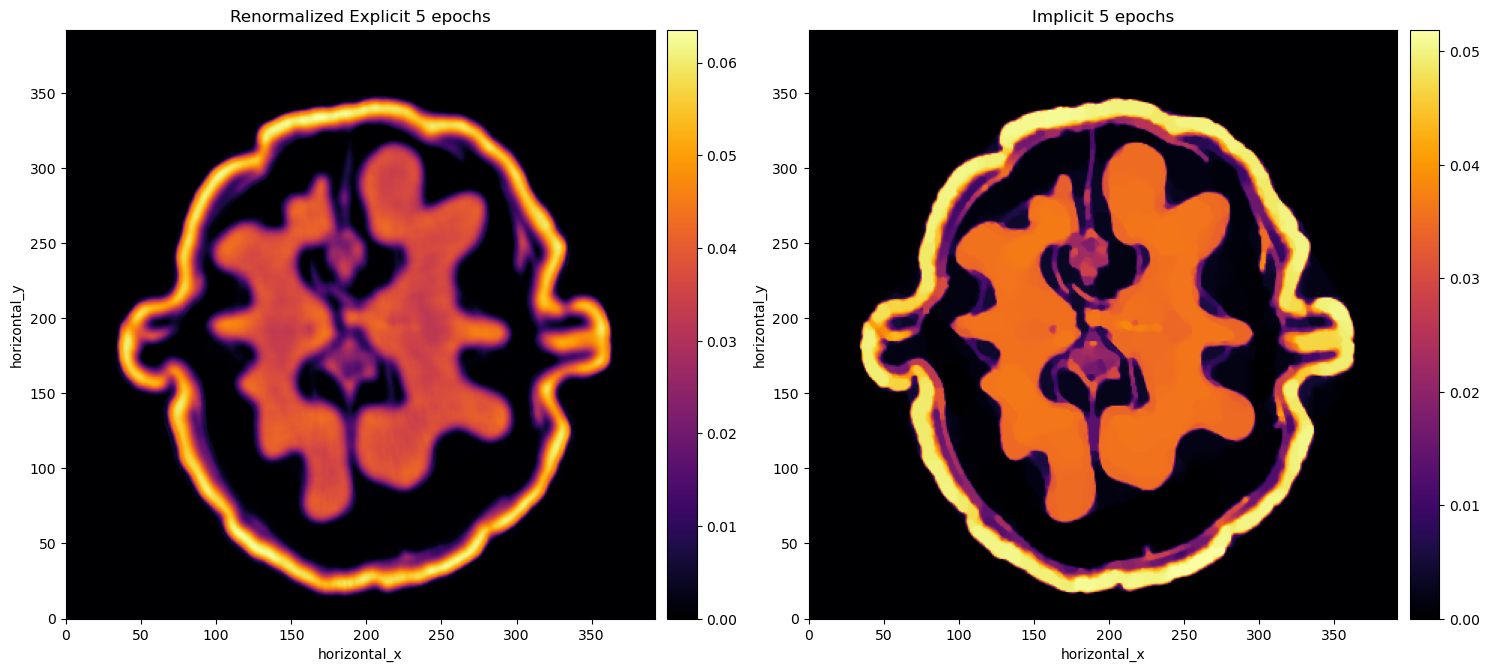

In [16]:
# Show result and compare to implicit framework
spdhg_explicit_recon = spdhg_explicit.get_output()  
show2D([spdhg_explicit_recon, spdhg_recon], cmap='inferno', title= ['Renormalized Explicit 5 epochs','Implicit 5 epochs'])

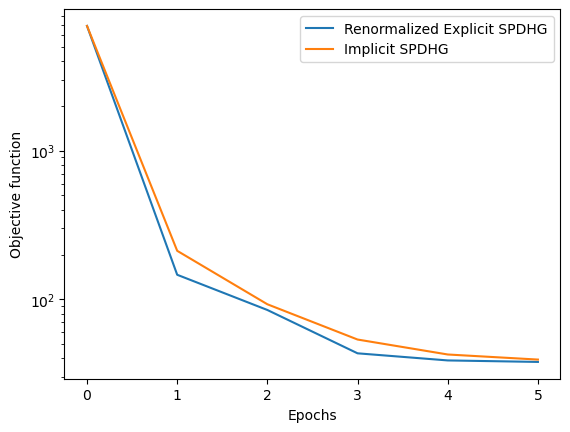

In [17]:
# Comparison of objective function
epoch_range = np.arange(0,6)
plt.semilogy(epoch_range, spdhg_explicit.objective, label='Renormalized Explicit SPDHG')
plt.semilogy(epoch_range, spdhg_measures[0:len(epoch_range)], label='Implicit SPDHG')
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.legend()

## When to use explicit or implicit framework?

1. Set-up: implicit framework is generally easier to set-up

1. Time-per-iteration: the time-per-iteration is greater in the implicit framework; indeed, at each iteration one needs to compute the proximal operator of the TV, which is done by in a (hidden) inner loop. This does not occur in the explicit framework, where all the operators have explicit expressions (hence its name.)

1. Speed of convergence: there is no theoretical result as to which framework is the fastest. In the example above, one can observe that renormalized explicit SPDHG seems to converge at roughly the same speed than implicit SPDHG.


## Theoretical background


**Algorithm**

SPDHG is described as follows:

1. **Input:** Step-sizes $\tau, (\sigma_i)_{1\leq i \leq n}$, $\tau$; probabilities $p_i$
1. **Initialize:** $x=0$, $y=0$, $z = \bar{z} = A^T y = 0$
1. **Iterate** for $m=1, \dots$:

    1. Update primal variable: 
        $$x = \text{prox}_{\tau g}(x - \tau \bar{z}) $$
    1. Pick index $i$ at random with probability $p_i$
        $$ $$
    1. Update dual variable with index $i$: 
        $$ y_i^+ = \text{prox}_{\sigma_i f_i^*}(y_i + \sigma_i A_i x) $$
    1. Update secondary variables: 
        $$ d z = A_i^T(y_i^+ - y_i), \quad z = z + d z, \quad y_i = y_i^+ $$
    1. Perform extrapolation step:     
        $$ \bar{z}= z + (1/p_i) \cdot d z $$

**Admissible step-sizes**

SPDHG converges to the set of solutions of the saddle-point problem (in terms of Bregman distance [ref] and almost surely [ref1, ref2]) if the following conditions on step-sizes $\tau, (\sigma_i)_{1\leq i \leq n}$ is verified:
$$ \tau \, \sigma_i \, \|K_i\|^2 < p_i^2, \quad 1 \leq i \leq n$$

CIL default implementation is $\sigma_i = \rho/\|K_i\|$ for all $i$'s and $\tau =\rho\, \min_i p_i^2/\|K_i\|$ with $\rho=0.99$.


Other admissible choices would be $\sigma_i = \gamma \rho/\|K_i\|$ for all $i$'s and $\tau =\rho\, \min_i p_i^2/\|K_i\| / \gamma$ with $\rho=0.99$. Changing the value of $\gamma$ allows to change the balance between primal and dual convergence. It can be changed in the following way:

` spdhg = SPDHG(f = F, g = G, operator = K, gamma = gamma)`





